In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # 新增：可视化库
import seaborn as sns  # 新增：统计可视化库
sns.set(style="whitegrid", font_scale=1.2)  # 新增：设置可视化风格

In [23]:
# 1. 加载数据
file_path = "/Users/Yang/Desktop/BTC_USDT_1h.csv"
df = pd.read_csv(file_path)

In [24]:
# 转换时间戳为datetime格式（假设timestamp列为毫秒级）
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('datetime', inplace=True)

# 检查缺失值
print("缺失值统计:")
print(df.isnull().sum())

# 前向填充缺失值（如果有）
df = df.ffill()

# 验证填充结果
print("\n填充后缺失值统计:")
print(df.isnull().sum())

缺失值统计:
timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

填充后缺失值统计:
timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64


In [25]:
# 特征工程
# 价格波动范围
df['price_range'] = df['high'] - df['low']

# 涨跌幅（百分比变化）
df['price_change_pct'] = df['close'].pct_change() * 100

# 简单移动平均（4小时窗口）
df['sma_4'] = df['close'].rolling(window=4).mean()

# 交易量变化
df['volume_change'] = df['volume'].pct_change()

# 时间特征
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek  # Monday=0, Sunday=6
df['month'] = df.index.month
df['quarter'] = df.index.quarter

# 新增交易量相关特征
df['volume_sma_4'] = df['volume'].rolling(window=4).mean()
df['volume_std_4'] = df['volume'].rolling(window=4).std()

In [26]:
# ====================== 新增内容：高级时间特征 ======================
# 1. 周期性特征（正弦/余弦编码，增强时间序列周期性）
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)  # 新增：小时正弦编码
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)  # 新增：小时余弦编码
df['dayofweek_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)  # 新增：星期正弦编码
df['dayofweek_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)  # 新增：星期余弦编码

# 2. 交易日标识（区分周末/交易日，周末=0，交易日=1）
df['is_trading_day'] = np.where(df['day_of_week'].isin([5, 6]), 0, 1)  # 新增：周末标识

In [27]:
# ====================== 新增内容：复杂技术指标 ======================
# 1. MACD指标（12, 26, 9）
close_price = df['close']
ema12 = close_price.rolling(window=12).mean()  # 新增：12期指数移动平均
ema26 = close_price.rolling(window=26).mean()  # 新增：26期指数移动平均
df['macd'] = ema12 - ema26  # 新增：MACD值
df['macd_signal'] = df['macd'].rolling(window=9).mean()  # 新增：MACD信号线
df['macd_diff'] = df['macd'] - df['macd_signal']  # 新增：MACD柱状图差值

# 2. 动量指标（14期动量）
n = 14
df['momentum'] = df['close'] / df['close'].shift(n) - 1  # 新增：动量特征


In [28]:
# ====================== 新增内容：特征交互 ======================
# 量价交叉特征（反映量价协同效应）
df['volatility_vol'] = df['price_range'] * df['volume']  # 新增：波动与交易量乘积
df['return_vol_corr'] = df['price_change_pct'].rolling(window=5).corr(df['volume_change'])  # 新增：收益与交易量相关性


In [29]:
# 处理特征中的NaN（由于rolling计算产生）
df.dropna(inplace=True)

In [30]:
# 存入新对象df_clean。删除包含NaN的行（确保所有特征有效）
df_clean = df.dropna().copy()  # 存入新对象df_clean

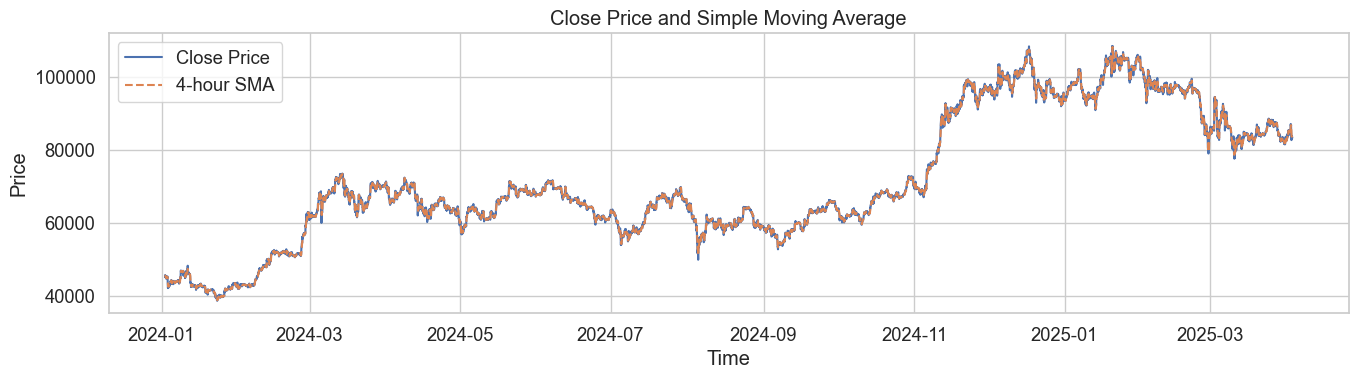

In [31]:
# ====================== 新增内容：特征工程可视化图表 ======================
# ------------------------ 1. 时间序列特征可视化 ------------------------
plt.figure(figsize=(16, 8))

# 子图1：收盘价与简单移动平均
plt.subplot(2, 1, 1)
plt.plot(df_clean['close'], label='Close Price')
plt.plot(df_clean['sma_4'], label='4-hour SMA', linestyle='--')
plt.title('Close Price and Simple Moving Average')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

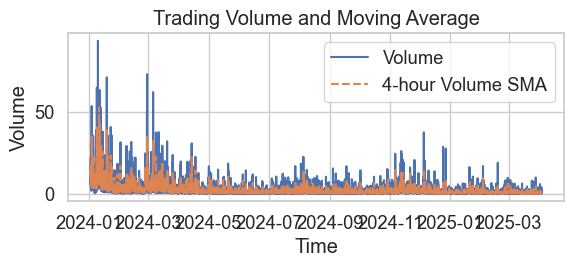

In [32]:
# 子图2：交易量与交易量移动平均
plt.subplot(2, 1, 2)
plt.plot(df_clean['volume'], label='Volume')
plt.plot(df_clean['volume_sma_4'], label='4-hour Volume SMA', linestyle='--')
plt.title('Trading Volume and Moving Average')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()

In [33]:
plt.tight_layout()
plt.show()  # 新增：显示时间序列图

<Figure size 640x480 with 0 Axes>

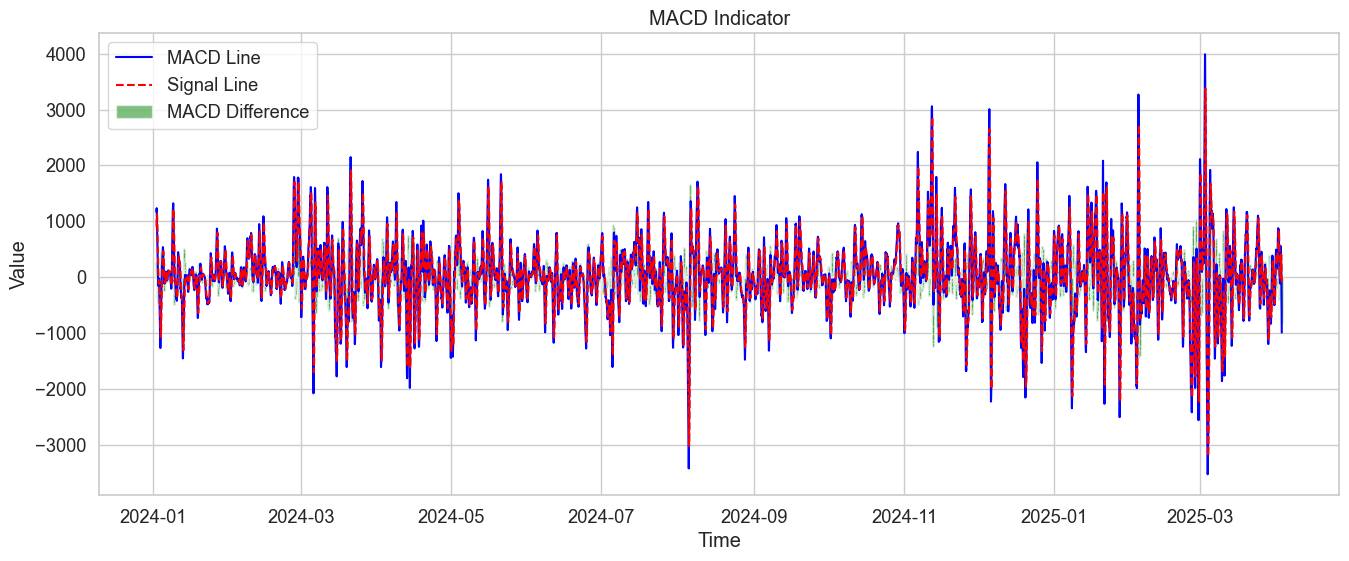

In [41]:
# ------------------------ 2. MACD指标可视化 ------------------------
plt.figure(figsize=(16, 6))
plt.plot(df_clean['macd'], label='MACD Line', color='blue')
plt.plot(df_clean['macd_signal'], label='Signal Line', color='red', linestyle='--')
plt.bar(df_clean.index, df_clean['macd_diff'], label='MACD Difference', color='green', alpha=0.5)
plt.title('MACD Indicator')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()  # 新增：显示MACD指标图

In [40]:
# 验证处理后的数据：直接显示索引（datetime）和其他列
print("\n（datetime作为索引）：")
print("特征列表（原代码+新增）：", df_clean.columns.tolist())
print("\n前5行数据：")
print(df_clean[['open', 'high', 'low', 'close', 'volume', 'price_range', 'price_change_pct', 'sma_4', 'volume_change', 'hour', 'day_of_week', 'month', 'quarter', 'volume_sma_4', 'volume_std_4', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'is_trading_day', 'macd', 'macd_signal', 'macd_diff', 'momentum', 'volatility_vol', 'return_vol_corr']].head())
print(df_clean.index[:5])

# 检查形状变化
print(f"\n原始数据行数: {len(df)} → 处理后行数: {len(df_clean)} (删除了{len(df) - len(df_clean)}行NaN)")


（datetime作为索引）：
特征列表（原代码+新增）： ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'price_range', 'price_change_pct', 'sma_4', 'volume_change', 'hour', 'day_of_week', 'month', 'quarter', 'volume_sma_4', 'volume_std_4', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'is_trading_day', 'macd', 'macd_signal', 'macd_diff', 'momentum', 'volatility_vol', 'return_vol_corr']

前5行数据：
                         open      high       low     close    volume  \
datetime                                                                
2024-01-02 09:00:00  45753.95  45889.62  45627.95  45676.46  10.47817   
2024-01-02 10:00:00  45692.90  45727.74  45449.58  45556.41   5.30084   
2024-01-02 11:00:00  45556.41  45690.91  45220.08  45406.03   7.24278   
2024-01-02 12:00:00  45442.14  45581.19  45237.70  45267.76  13.44565   
2024-01-02 13:00:00  45301.99  45699.09  45253.88  45635.07   7.47780   

                     price_range  price_change_pct       sma_4  volume_change  \
datetime       